# Modelling and Evaluating 

## Objectives

- Answer business requirement 2:
  - The client is interested to tell wheterh a given leaf is covered with powdery mildew 

## Inputs

- image shape embeddings (pickle file)
- Images from the test, train, validation folders and their subfolders. 
    ```bash
    . 
    ├── inputs 
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves                                     
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew                   
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew          
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew                 
    └── ...
    ```

* Images distribution plot in train, validation, and test set.
  * label distribution - bar chart
  * set distriburion - pie chart (percentages)
* Image augmentation.
  * plot augmented images for each set.
* Class indices to change prediction inference in labels.
* Creation of a Machine learning model and display of its summary
* Model training. 
* Save model.
* Learning curve plot for model performance.
  * Model A - separate plots for accuracy and loss
  * Model B - comprehensive model history plot 
  * Model C - plot model history with plotly
* Model evaluation on saved file.
  * calculate accuracy
  * plot ROC curve
  * calculate classification report (Model A)
    * Model B - classification report with macro avg and weighted avg
    * Model C - syntetic classification report per label
* Plot Confusion Matrix
* Save evaluation pickle file
* Prediction on the random image file.

## Comments | Insights

- The same data was plotted in different versions to accomodate possible client's requests of further data understanding. 
- The CNN was built seeking maximise accuracy while minimizing loss and training time.
- The CNN was kept as small as possible withouth compromising accuracy and avoiding overfitting. 
- More about hyperparameters optimization and trial and error phase is documented in the readme.md file and in a separate .pdf file.

---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

## Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/CLMP-Detector/')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/CLMP-Detector'

---

## Set input directories

In [5]:
# Define input paths for training, validation, and testing datasets

data_directory = 'inputs/cherryleaves_dataset/cherry-leaves'
train_dir = data_directory + '/train'
validation_dir = data_directory + '/validation'
test_dir = data_directory + '/test'

## Set output directory

In [6]:
# Set the output directory for saving model results and Create a new version if necessary.

version = 'v1'
file_path = os.path.join('outputs', version)

if os.path.exists(os.path.join(work_dir, 'outputs')) and os.path.exists(file_path):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)

Old version is already available, create a new version.


## Set Label names

In [7]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image Distribution

### Count the number of images per set and label

In [9]:
# Prepare an empty DataFrame for counting images
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Count'])

# Loop through each folder (train, test, validation) and count images in each label (healthy, powdery_mildew)
for folder in ['train', 'test', 'validation']:
    for label in labels:
        count = len(os.listdir(os.path.join(data_directory, folder, label)))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Count': count}, ignore_index=True)
        print(f"* {folder} - {label}: {count} images")

print("\n", df_freq)

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images

           Set           Label Count
0       train         healthy  1472
1       train  powdery_mildew  1472
2        test         healthy   422
3        test  powdery_mildew   422
4  validation         healthy   210
5  validation  powdery_mildew   210


### Label Distribution - Bar Chart

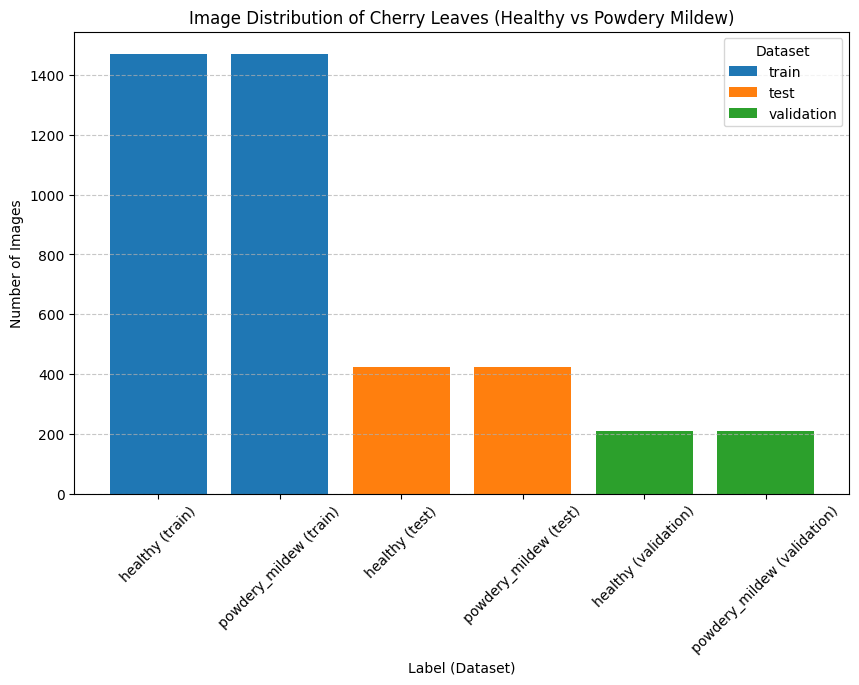

In [10]:
# Bar plot to visualize the image distribution
plt.figure(figsize=(10, 6))
for folder in ['train', 'test', 'validation']:
    subset = df_freq[df_freq['Set'] == folder]
    plt.bar(subset['Label'] + ' (' + folder + ')', subset['Count'], label=folder)

# Adding labels and title
plt.title('Image Distribution of Cherry Leaves (Healthy vs Powdery Mildew)')
plt.xlabel('Label (Dataset)')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Set Distribution - Pie Chart

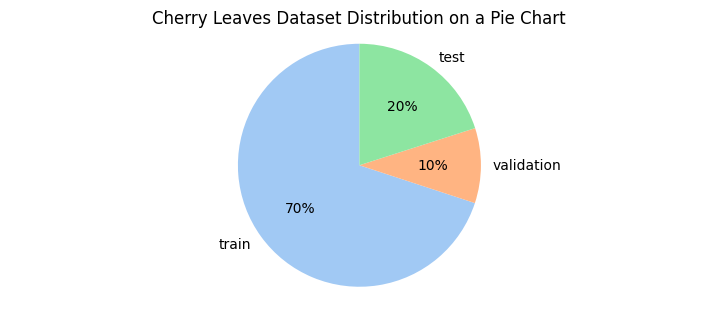

In [11]:
# Define the folder names for train, validation, and test sets
folders = ['train', 'validation', 'test']

# Initialize variables to store data distribution across sets
data = []

# Loop through the folders (train, validation, test) and count the number of images for each
for folder in folders:
    n = 0
    for label in labels:
        n += len(os.listdir(os.path.join(data_directory, folder, label)))
    data.append(n)

# Create the pie chart using Matplotlib
px = 1 / plt.rcParams['figure.dpi']  # Adjusting size for display
plt.subplots(figsize=(900 * px, 350 * px))
colors = sns.color_palette('pastel')[0:5]  # Using pastel colors for the pie chart
plt.pie(data, labels=folders, colors=colors, autopct='%.0f%%', startangle=90)
plt.title('Cherry Leaves Dataset Distribution on a Pie Chart')
plt.axis('equal')  # Ensures pie chart is a perfect circle
plt.savefig(f'{file_path}/sets_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()


---

## Image Data Augmentation

In [12]:
# Import necessary libraries for modeling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

### Data Preprocessing – Image Augmentation

In [13]:
# Data Preprocessing: Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Set Batch size

In [14]:
batch_size = 20

### Augment training image set

In [15]:
train_set = train_datagen.flow_from_directory(train_dir,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Training Images

(20, 256, 256, 3)


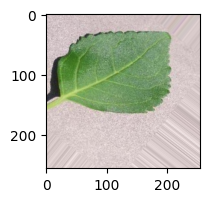

(20, 256, 256, 3)


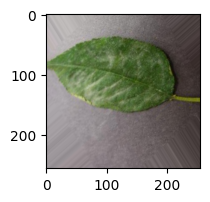

(20, 256, 256, 3)


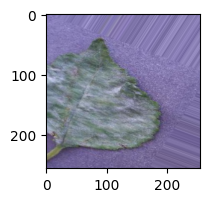

In [16]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [17]:
validation_set = validation_datagen.flow_from_directory(validation_dir, 
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices  # Display the class indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Validation Images

(20, 256, 256, 3)


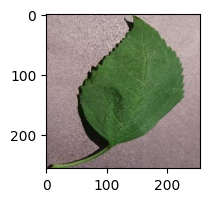

(20, 256, 256, 3)


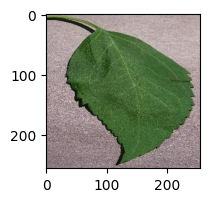

(20, 256, 256, 3)


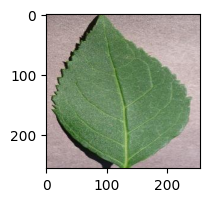

In [18]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Test Image Set

In [19]:
test_set = test_datagen.flow_from_directory(test_dir, 
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices  # Display the class indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Test Images

(20, 256, 256, 3)


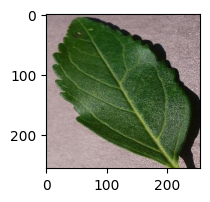

(20, 256, 256, 3)


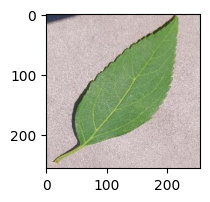

(20, 256, 256, 3)


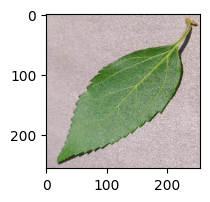

In [20]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Build the CNN Model

This step involves building the CNN model with convolutional, pooling, flattening, and dense layers.

In [22]:
# Model Building
model = Sequential()

# Add Convolutional Layers
# First convolutional layer with 32 filters
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))   
model.add(MaxPooling2D(pool_size=(2, 2)))   # First max pooling layer

# Second convolutional layer with 32 filters
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   # Second max pooling layer

# Third convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   # Third max pooling layer

# Add Flattening and Dense Layers
# Flatten the output from the convolutional layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))     # Fully connected layer with 64 neurons
model.add(Dropout(0.5))  # Add dropout to prevent overfitting

2024-09-22 12:45:41.729512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Add Output Layer and Compile the Model

In [23]:
# Add the output layer

# Output layer with 2 neurons for binary classification using softmax activation
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',                 # Optimizer to use during training
            loss='categorical_crossentropy',    # Loss function for multi-class classification
            metrics=['accuracy'])               # Metrics to track during training and evaluation

### Model Summary

In [24]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

Callbacks

In [25]:
early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

### Train the Model with Early Stopping

In [26]:
# Train the model using the training dataset
history = model.fit(
    train_set,      # Input training data
    epochs=25,      # Number of epochs to train the model
    steps_per_epoch=len(train_set.classes) // batch_size,   # Steps per epoch based on training data size
    validation_data=validation_set,                         # Validation dataset to monitor performance
    callbacks=[early_stop, m_checkpoint],       # Callbacks for early stopping and model checkpointing
    verbose=1       # Verbosity mode; 1 will display progress during training
)


2024-09-22 12:45:42.071231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
  6/147 [>.............................] - ETA: 1:21 - loss: 1.3411 - accuracy: 0.4327

147/147 [==============================] - 103s 699ms/step - loss: 0.5217 - accuracy: 0.7209 - val_loss: 0.0526 - val_accuracy: 0.9881
Epoch 2/25
147/147 [==============================] - 107s 726ms/step - loss: 0.2590 - accuracy: 0.8995 - val_loss: 0.0341 - val_accuracy: 0.9881
Epoch 3/25
147/147 [==============================] - 103s 701ms/step - loss: 0.1479 - accuracy: 0.9343 - val_loss: 0.0426 - val_accuracy: 0.9881
Epoch 00003: early stopping


### Load saved best model

In [27]:
from keras.models import load_model

load_model('outputs/v1/powdery_mildew_model.h5')

---

## Model Performance

### Plot Learning Curves

### Visualize the training and validation accuracy/loss across epochs.

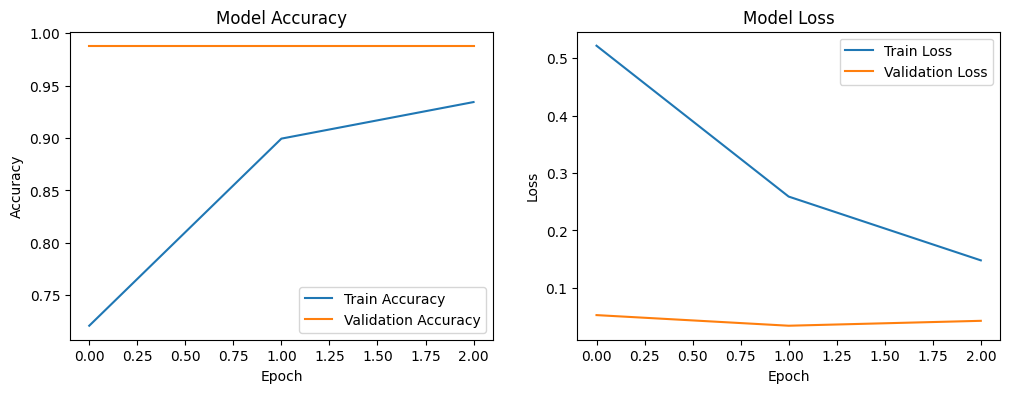

In [28]:
# Set the figure size for the plots
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)    # Create a subplot for accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')   # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')     # Set the title for the accuracy plot
plt.ylabel('Accuracy')      # Label the y-axis  
plt.xlabel('Epoch')         # Label the x-axis
plt.legend()    # Display the legend

# Loss Plot
plt.subplot(1, 2, 2)    # Create a subplot for loss
plt.plot(history.history['loss'], label='Train Loss')   # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')     # Set the title for the loss plot
plt.ylabel('Loss')      # Label the y-axis
plt.xlabel('Epoch')     # Label the x-axis
plt.legend()            # Display the legend

# Show the plots
plt.show()


### Evaluate the Model on Test Data

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test ImageDataGenerator for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset from the directory
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_shape[:2],  # Match the input size for the model
    batch_size=32,                # Batch size for evaluation
    class_mode='categorical',      # Use 'categorical' since this is a multi-class classification
    shuffle=False                 # No need to shuffle for evaluation
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate accuracy percentage and print it
print("Model accuracy: {:.2f}%".format(test_accuracy * 100))

Found 844 images belonging to 2 classes.
27/27 [==============================] - 8s 286ms/step - loss: 0.0397 - accuracy: 0.9893
Test Loss: 0.03965859115123749, Test Accuracy: 0.9893364906311035
Model accuracy: 98.93%


### Set accuracy variables

In [30]:
# Reset the validation set to prepare for new predictions
validation_set.reset()

# Get the next batch of data from the test set (features and labels)
x_true, y_true = next(test_set)

# Make predictions using the model and take the class with the highest probability
preds = np.argmax(model.predict(test_set), axis=1)

# Round the predicted values to obtain binary class labels
y_pred = np.rint(preds)

# Extract the true labels from the test set
y_true = test_set.labels

### ROC Curve

Area Under ROC-Curve:  0.9893364928909952


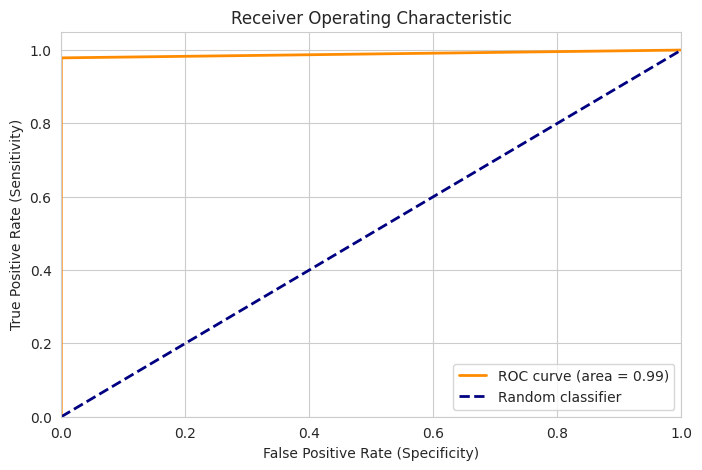

In [31]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

# Set the style for the seaborn plot
sns.set_style("whitegrid")

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Set up the figure size for the ROC curve plot
plt.figure(figsize=(8, 5))
lw = 2       # Line width for the plots

# Plot the ROC curve with the calculated true positive and false positive rates
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot a diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')

# Set limits for the axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Label the axes
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Set the title of the plot
plt.title('Receiver Operating Characteristic')

# Display the legend in the lower right corner
plt.legend(loc="lower right")

# Save the ROC curve figure to the specified file path
plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)

# Print the area under the ROC curve
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))

# Display the plot
plt.show()

Confusion Matrix

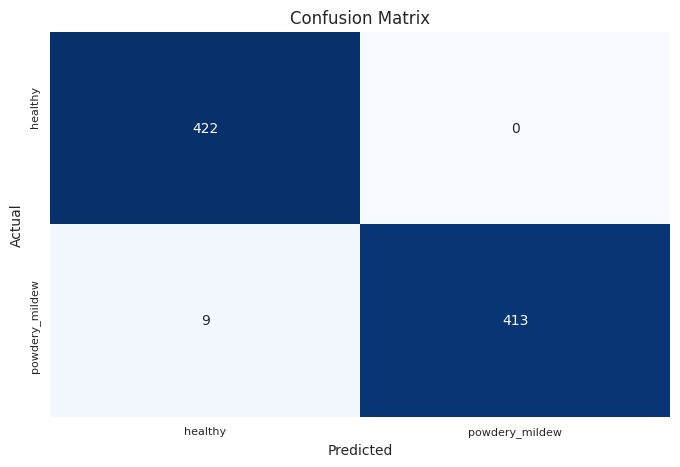

In [32]:
# Calculate the confusion matrix from true and predicted labels
cm = confusion_matrix(y_true,y_pred)

# Get the list of class names from the test set
classes=list(test_set.class_indices.keys()) 
length=len(classes)

# Set up the figure size for the heatmap
plt.figure(figsize=(8, 5))

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# Set x-ticks to display class names, centered under the corresponding columns
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)

# Set y-ticks to display class names, aligned with the corresponding rows
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)

# Label the axes
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title of the plot
plt.title("Confusion Matrix")

# Save the confusion matrix figure to the specified file path
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)

# Display the plot
plt.show()

### Classification Report - A

In [33]:
# Make predictions on the test set
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report with class labels
cr = classification_report(test_set.classes, predicted_classes, target_names=labels)
print("Classification Report:")
print(cr)

Classification Report:
                precision    recall  f1-score   support

       healthy       0.98      1.00      0.99       422
powdery_mildew       1.00      0.98      0.99       422

      accuracy                           0.99       844
     macro avg       0.99      0.99      0.99       844
  weighted avg       0.99      0.99      0.99       844



### Classification Report B

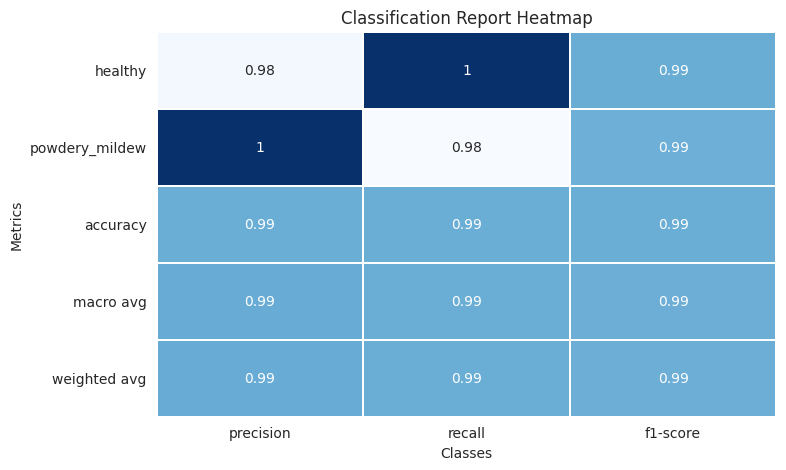

In [34]:
# Generate the classification report with class labels
clf_report = classification_report(test_set.classes, predicted_classes, target_names=labels, output_dict=True)

# Create a heatmap for the classification report
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)

plt.title('Classification Report Heatmap')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

### Classification Report C

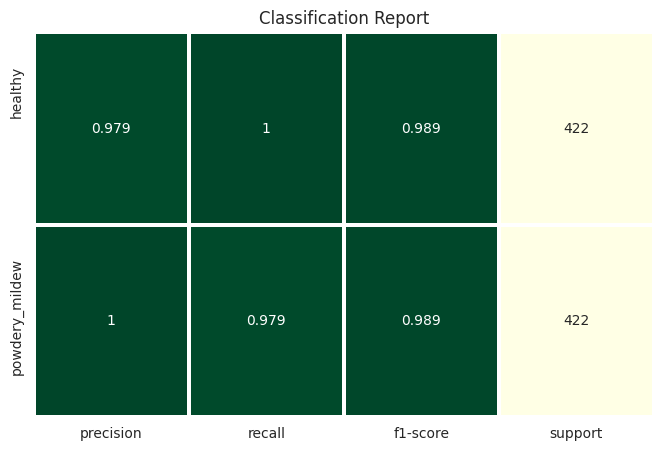

In [35]:
import matplotlib as mpl
import pathlib

def plot_classification_report(y_test, y_pred, title='Classification Report', save_fig_path=None, **kwargs):
   
    # Create a figure and axis for the plot with specified size
    fig, ax = plt.subplots(figsize=(8,5))
    
    # Generate a classification report and output it as a dictionary
    clf_report = classification_report(y_true, y_pred, output_dict=True, **kwargs)
    
     # Select keys to plot, excluding accuracy and averages
    keys_to_plot = [key for key in clf_report.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
    
    # Convert the classification report dictionary into a DataFrame and transpose it
    df = pd.DataFrame(clf_report, columns=keys_to_plot).T
    
    #the following line ensures that dataframe are sorted from the majority classes to the minority classes
    df.sort_values(by=['support'], inplace=True) 
    
    #First, Plot the heatmap by masking the 'support' column
    rows, cols = df.shape
    mask = np.zeros(df.shape)
    mask[:,cols-1] = True   # Mask the last column (support)
    
    # Create a heatmap for the main classification metrics
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", fmt='.3g', cbar=False,
            vmin=0.0,
            vmax=1.0,
            linewidths=.4, linecolor='white'
                    )
    
    #Then, Add the support column by normalizing the colors in this column
    mask = np.zeros(df.shape)
    mask[:,:cols-1] = True    
    
    # Create a heatmap for the support column with normalization
    ax = sns.heatmap(df, mask=mask, annot=True, cmap="YlGn", cbar=False,
            linewidths=2, linecolor='white', fmt='.0f',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),         
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum())
                    ) 

    # Set the title of the plot      
    plt.title(title)

    # Set y-ticks to display class names and rotate them for better visibility
    plt.yticks(np.arange(length)+.2, classes, rotation=90)

    # If a path is provided, save the figure to that location     
    if (save_fig_path != None):
        path = pathlib.Path(save_fig_path)
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_fig_path)
    
    return fig, ax  # Return the figure and axis objects

# Call the function to plot the classification report with specified parameters
fig, ax = plot_classification_report(y_true, y_pred, 
                    title='Classification Report',
                    target_names=labels,
                    save_fig_path = f'{file_path}/clf_report.png',)

### Predict on new data

### Load a Random Image as PIL

Image shape: (256, 256), Image mode: RGB


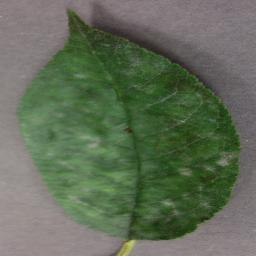

In [36]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_dir + '/' + label + '/' + os.listdir(test_dir+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

### Convert image to array and prepare for prediction

In [37]:
# Convert image to array using numpy
my_image = np.array(pil_image) / 255.0  # Normalize directly by dividing
print(f"Shape after converting to array: {my_image.shape}")

# Add batch dimension
# Equivalent to np.expand_dims(my_image, axis=0)
my_image = my_image[None, ...]  
print(f"Final shape with batch dimension: {my_image.shape}")


Shape after converting to array: (256, 256, 3)
Final shape with batch dimension: (1, 256, 256, 3)


### Predict Class Probabilities

In [55]:
# Predict the class probabilities for the image
pred_proba = model.predict(my_image)[0]

# Reverse the mapping from index to class label
target_map = {v: k for k, v in train_set.class_indices.items()}

# Determine the predicted class based on the probability threshold
if pred_proba[1] >= 0.5:  # Check the probability for 'powdery_mildew'
    pred_class = target_map[1]  # Corresponds to 'powdery_mildew'
    pred_proba_value = pred_proba[1]  # Get the probability for 'powdery_mildew'
else:
    pred_class = target_map[0]  # Corresponds to 'healthy'
    pred_proba_value = 1 - pred_proba[1]  # Adjust probability for 'healthy'

# Print the result
print(f"{pred_class} - {round(pred_proba_value * 100, 2)}%")

powdery_mildew - 99.95%
